# Wolf-Sheep-Grass Model with Soil Creep

This notebook demonstrates coupling of an ABM implemented in Mesa and a grid-based numerical model written in Landlab. The example is the canonical "wolf-sheep-grass" example of an agent-based model. Here we add an additional twist: when sheep eat grass, the soil beneath becomes more easily mobile. This then influences soil transport: the transport efficiency is higher where the grass is "damaged". An additional feedback lies in the thickness of the soil: grass will not grow if the soil is too thin.

The rules in this example are deliberately simple. The main goal of this tutorial is to illustrate the mechanics of building an integrated model that combines agent-based elements (via Mesa) with continuum-based elements (via Landlab) on a shared grid.

*(Greg Tucker, June 2020; most recent update November 2021)*

## Running the Mesa Wolf-Sheep-Grass model by itself

To start, here's an example of how to run a Mesa model in a notebook. First, we'll run a check to make sure Mesa is installed and available; if it is not, follow the instructions in the message to install it, then re-start the kernel (Kernel => Restart) and continue.

In [1]:
try:
    from mesa import Model
except ModuleNotFoundError:
    print(
        """
Mesa needs to be installed in order to run this notebook.

Normally Mesa should be pre-installed alongside the Landlab notebook collection.
But it appears that Mesa is not already installed on the system on which you are
running this notebook. You can install Mesa from a command prompt using either:

`conda install -c conda-forge mesa`

or

`pip install mesa`
"""
    )
    raise

Next, we'll define a Mesa model object, representing the wolf-sheep-grass model, along with an agent object, representing grass patches. Note that this Mesa code in the cell below, which implements the wolf-sheep-grass example, was written by the Mesa development team; the original can be found [here](https://github.com/projectmesa/mesa/tree/main/examples/wolf_sheep).

In [8]:
from collections import defaultdict

from mesa import Agent
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation


class RandomActivationByBreed(RandomActivation):
    """
    A scheduler which activates each type of agent once per step, in random
    order, with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask breed...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step() method.
    """

    def __init__(self, model):
        super().__init__(model)
        self.agents_by_breed = defaultdict(dict)

    def add(self, agent):
        """
        Add an Agent object to the schedule

        Args:
            agent: An Agent to be added to the schedule.
        """

        self._agents[agent.unique_id] = agent
        agent_class = type(agent)
        self.agents_by_breed[agent_class][agent.unique_id] = agent

    def remove(self, agent):
        """
        Remove all instances of a given agent from the schedule.
        """

        del self._agents[agent.unique_id]

        agent_class = type(agent)
        del self.agents_by_breed[agent_class][agent.unique_id]

    def step(self, by_breed=True):
        """
        Executes the step of each agent breed, one at a time, in random order.

        Args:
            by_breed: If True, run all agents of a single breed before running
                      the next one.
        """
        if by_breed:
            for agent_class in self.agents_by_breed:
                self.step_breed(agent_class)
            self.steps += 1
            self.time += 1
        else:
            super().step()

    def step_breed(self, breed):
        """
        Shuffle order and run all agents of a given breed.

        Args:
            breed: Class object of the breed to run.
        """
        agent_keys = list(self.agents_by_breed[breed].keys())
        self.model.random.shuffle(agent_keys)
        for agent_key in agent_keys:
            self.agents_by_breed[breed][agent_key].step()

    def get_breed_count(self, breed_class):
        """
        Returns the current number of agents of certain breed in the queue.
        """
        return len(self.agents_by_breed[breed_class].values())


class RandomWalker(Agent):
    """
    Class implementing random walker methods in a generalized manner.

    Not indended to be used on its own, but to inherit its methods to multiple
    other agents.

    """

    grid = None
    x = None
    y = None
    moore = True

    def __init__(self, unique_id, pos, model, moore=True):
        """
        grid: The MultiGrid object in which the agent lives.
        x: The agent's current x coordinate
        y: The agent's current y coordinate
        moore: If True, may move in all 8 directions.
                Otherwise, only up, down, left, right.
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore

    def random_move(self):
        """
        Step one cell in any allowable direction.
        """
        # Pick the next cell from the adjacent cells.
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        # Now move:
        self.model.grid.move_agent(self, next_move)


class Sheep(RandomWalker):
    """
    A sheep that walks around, reproduces (asexually) and gets eaten.

    The init is the same as the RandomWalker.
    """

    energy = None

    def __init__(self, unique_id, pos, model, moore, energy=None):
        super().__init__(unique_id, pos, model, moore=moore)
        self.energy = energy

    def step(self):
        """
        A model step. Move, then eat grass and reproduce.
        """
        self.random_move()
        living = True

        if self.model.grass:
            # Reduce energy
            self.energy -= 1

            # If there is grass available, eat it
            this_cell = self.model.grid.get_cell_list_contents([self.pos])
            grass_patch = [obj for obj in this_cell if isinstance(obj, GrassPatch)][0]
            if grass_patch.fully_grown:
                self.energy += self.model.sheep_gain_from_food
                grass_patch.fully_grown = False

            # Death
            if self.energy < 0:
                # self.model.grid._remove_agent(self.pos, self)
                self.model.grid.remove_agent(self)
                self.model.schedule.remove(self)
                living = False

        if living and self.random.random() < self.model.sheep_reproduce:
            # Create a new sheep:
            if self.model.grass:
                self.energy /= 2
            lamb = Sheep(
                self.model.next_id(), self.pos, self.model, self.moore, self.energy
            )
            self.model.grid.place_agent(lamb, self.pos)
            self.model.schedule.add(lamb)


class Wolf(RandomWalker):
    """
    A wolf that walks around, reproduces (asexually) and eats sheep.
    """

    energy = None

    def __init__(self, unique_id, pos, model, moore, energy=None):
        super().__init__(unique_id, pos, model, moore=moore)
        self.energy = energy

    def step(self):
        self.random_move()
        self.energy -= 1

        # If there are sheep present, eat one
        x, y = self.pos
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        sheep = [obj for obj in this_cell if isinstance(obj, Sheep)]
        if len(sheep) > 0:
            sheep_to_eat = self.random.choice(sheep)
            self.energy += self.model.wolf_gain_from_food

            # Kill the sheep
            # self.model.grid._remove_agent(self.pos, sheep_to_eat)
            self.model.grid.remove_agent(sheep_to_eat)
            self.model.schedule.remove(sheep_to_eat)

        # Death or reproduction
        if self.energy < 0:
            # self.model.grid._remove_agent(self.pos, self)
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
        else:
            if self.random.random() < self.model.wolf_reproduce:
                # Create a new wolf cub
                self.energy /= 2
                cub = Wolf(
                    self.model.next_id(), self.pos, self.model, self.moore, self.energy
                )
                self.model.grid.place_agent(cub, cub.pos)
                self.model.schedule.add(cub)


class GrassPatch(Agent):
    """
    A patch of grass that grows at a fixed rate and it is eaten by sheep
    """

    def __init__(self, unique_id, pos, model, fully_grown, countdown):
        """
        Creates a new patch of grass

        Args:
            grown: (boolean) Whether the patch of grass is fully grown or not
            countdown: Time for the patch of grass to be fully grown again
        """
        super().__init__(unique_id, model)
        self.fully_grown = fully_grown
        self.countdown = countdown
        self.pos = pos

    def step(self):
        if not self.fully_grown:
            if self.countdown <= 0:
                # Set as fully grown
                self.fully_grown = True
                self.countdown = self.model.grass_regrowth_time
            else:
                self.countdown -= 1


"""
Wolf-Sheep Predation Model
================================

Replication of the model found in NetLogo:
    Wilensky, U. (1997). NetLogo Wolf Sheep Predation model.
    http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation.
    Center for Connected Learning and Computer-Based Modeling,
    Northwestern University, Evanston, IL.
"""


class WolfSheep(Model):
    """
    Wolf-Sheep Predation Model
    """

    height = 20
    width = 20

    initial_sheep = 100
    initial_wolves = 50

    sheep_reproduce = 0.04
    wolf_reproduce = 0.05

    wolf_gain_from_food = 20

    grass = False
    grass_regrowth_time = 30
    sheep_gain_from_food = 4

    verbose = False  # Print-monitoring

    description = (
        "A model for simulating wolf and sheep (predator-prey) ecosystem modelling."
    )

    def __init__(
        self,
        height=20,
        width=20,
        initial_sheep=100,
        initial_wolves=50,
        sheep_reproduce=0.04,
        wolf_reproduce=0.05,
        wolf_gain_from_food=20,
        grass=False,
        grass_regrowth_time=30,
        sheep_gain_from_food=4,
    ):
        """
        Create a new Wolf-Sheep model with the given parameters.

        Args:
            initial_sheep: Number of sheep to start with
            initial_wolves: Number of wolves to start with
            sheep_reproduce: Probability of each sheep reproducing each step
            wolf_reproduce: Probability of each wolf reproducing each step
            wolf_gain_from_food: Energy a wolf gains from eating a sheep
            grass: Whether to have the sheep eat grass for energy
            grass_regrowth_time: How long it takes for a grass patch to regrow
                                 once it is eaten
            sheep_gain_from_food: Energy sheep gain from grass, if enabled.
        """
        super().__init__()
        # Set parameters
        self.height = height
        self.width = width
        self.initial_sheep = initial_sheep
        self.initial_wolves = initial_wolves
        self.sheep_reproduce = sheep_reproduce
        self.wolf_reproduce = wolf_reproduce
        self.wolf_gain_from_food = wolf_gain_from_food
        self.grass = grass
        self.grass_regrowth_time = grass_regrowth_time
        self.sheep_gain_from_food = sheep_gain_from_food

        self.schedule = RandomActivationByBreed(self)
        self.grid = MultiGrid(self.height, self.width, torus=True)
        self.datacollector = DataCollector(
            {
                "Wolves": lambda m: m.schedule.get_breed_count(Wolf),
                "Sheep": lambda m: m.schedule.get_breed_count(Sheep),
            }
        )

        # Create sheep:
        for i in range(self.initial_sheep):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.sheep_gain_from_food)
            sheep = Sheep(self.next_id(), (x, y), self, True, energy)
            self.grid.place_agent(sheep, (x, y))
            self.schedule.add(sheep)

        # Create wolves
        for i in range(self.initial_wolves):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            energy = self.random.randrange(2 * self.wolf_gain_from_food)
            wolf = Wolf(self.next_id(), (x, y), self, True, energy)
            self.grid.place_agent(wolf, (x, y))
            self.schedule.add(wolf)

        # Create grass patches
        if self.grass:
            for (agent, x, y) in self.grid.coord_iter():
                fully_grown = self.random.choice([True, False])

                if fully_grown:
                    countdown = self.grass_regrowth_time
                else:
                    countdown = self.random.randrange(self.grass_regrowth_time)

                patch = GrassPatch(self.next_id(), (x, y), self, fully_grown, countdown)
                self.grid.place_agent(patch, (x, y))
                self.schedule.add(patch)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if self.verbose:
            print(
                [
                    self.schedule.time,
                    self.schedule.get_breed_count(Wolf),
                    self.schedule.get_breed_count(Sheep),
                ]
            )

    def run_model(self, step_count=200):
        if self.verbose:
            print("Initial number wolves: ", self.schedule.get_breed_count(Wolf))
            print("Initial number sheep: ", self.schedule.get_breed_count(Sheep))

        for i in range(step_count):
            self.step()

        if self.verbose:
            print("")
            print("Final number wolves: ", self.schedule.get_breed_count(Wolf))
            print("Final number sheep: ", self.schedule.get_breed_count(Sheep))

Create an instance of the WolfSheep model, with the `grass` option set to `True`:

In [9]:
ws = WolfSheep(grass=True)

Define a function to set up an array representing the growth status of grass on the model grid (in other words, extract the information from the model's GrassPatch agents), as well as a function to plot the current grass status. This is really a translation of data structures: the Mesa model stores data inside agents, which themselves reside at particular grid cells. Here we want to extract the information pertaining to the status of each cell's GrassPatch---is it fully grown or "damaged"---and store that information in a simple 2D numpy array.

In [12]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

ground_cover_cmap = copy.copy(mpl.colormaps["YlGn"])


def generate_grass_map(model):
    grass_map = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        (cell_content, x, y) = cell
        for agent in cell_content:
            if type(agent) is GrassPatch:
                if agent.fully_grown:
                    grass_map[x][y] = 2
                else:
                    grass_map[x][y] = 1
    return grass_map


def plot_grass_map(grass_map):
    plt.imshow(grass_map, interpolation="nearest", cmap=ground_cover_cmap)
    plt.colorbar()

Run the model and display the results:

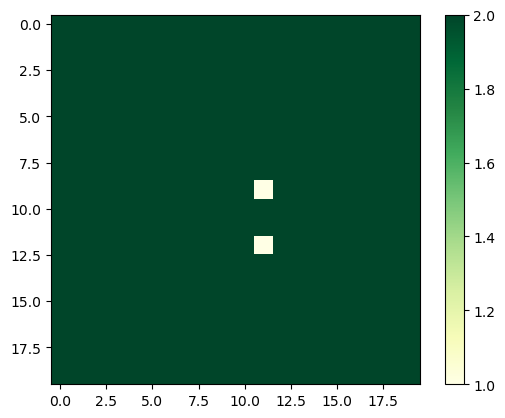

In [13]:
ws.run_model(step_count=25)
gm = generate_grass_map(ws)
plot_grass_map(gm)

## One-way coupling: using the grass cover in a soil-creep model

Here we initialize and run the W-S-G model for a short duration. We then extract its map of fully grown versus damaged grass, and use that to set the soil creep coefficient in a model of downslope soil creep. The point here is just to show that it's pretty easy to use a grid from a Mesa model as input to a Landlab-built model.

In [6]:
ws = WolfSheep(grass=True)
ws.run_model(step_count=3)
gm = generate_grass_map(ws)
plot_grass_map(gm)

ValueError: too many values to unpack (expected 2)

Import from Landlab a `RasterModelGrid` (which will be Landlab's version of the model grid), the `imshow_grid` function (for plotting Landlab grid fields), and the `LinearDiffuser` component (which will implement down-slope soil creep).

In [7]:
import copy

import matplotlib as mpl

from landlab import RasterModelGrid, imshow_grid
from landlab.components import LinearDiffuser

In [ ]:
# Create a grid the same size as the W-S-G model's grid
rmg = RasterModelGrid((ws.grid.width, ws.grid.height))

# Create elevation field and have it slope down to the south at 10% gradient
elev = rmg.add_zeros("topographic__elevation", at="node")
elev[:] = 0.1 * rmg.y_of_node

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = elev

# Create a field for the creep coefficient, and set parameters for two
# rates: slow (full grass cover) and fast (partial or "eaten" grass cover)
creep_coef = rmg.add_zeros("creep_coefficient", at="node")
fast_creep = 0.1
slow_creep = 0.001

# Assign the higher creep coefficient to cells where the grass has
# been eaten and not yet recovered; the slower value is assigned to
# "fully grown" grass patches.
creep_coef[gm.flatten() == 1] = fast_creep
creep_coef[gm.flatten() == 2] = slow_creep

# Instantiate a LinearDiffuser (soil creep) Landlab component
diffuser = LinearDiffuser(rmg, linear_diffusivity=creep_coef)

# Set the time step duration
dt = 0.2 * rmg.dx * rmg.dx / fast_creep
print(f"Time step duration is {dt} years.")

In [ ]:
# Run the soil creep model
for i in range(50):
    diffuser.run_one_step(dt)

In [ ]:
# Calculate and plot the erosion/deposition patterns
ero_dep = elev - initial_elev
maxchange = np.amax(np.abs(ero_dep))
imshow_grid(
    rmg,
    ero_dep,
    vmin=-maxchange,
    vmax=maxchange,
    cmap=copy.copy(mpl.colormaps["coolwarm_r"]),
    colorbar_label="Cumulative deposition (+) or erosion (-), m",
)

In [ ]:
# Plot the grass cover again
imshow_grid(
    rmg, gm, cmap=ground_cover_cmap, colorbar_label="Ground cover (1 = bare, 2 = grass)"
)

In [ ]:
imshow_grid(
    rmg,
    elev,
    cmap=copy.copy(mpl.colormaps["pink"]),
    colorbar_label="Elevation above base of slope (m)",
)

Interestingly, erosion tends to occur at locations where grass cover upslope captures incoming soil.

So far, however, this is just one-way feedback: the previously damaged grass patches, as calculated in the wolf-sheep-grass ABM, become susceptible to erosion, but this does not (yet) feed back into future grass growth or erosional loss. Let's turn to that next.

## Two-way feedback

Here, we explore two-way feedback by running the two models iteratively. We track soil thickness, and "damage" any grass where the soil is thinner than a given amount. We also limit soil flux according to its thickness, so that absent soil cannot move.

These rules are deliberately simple. One could make the model more realistic by, for example, setting the grass regrowth time (a property of the GrassPatch agents in the ABM) to a value that depends on the thickness of the soil (a Landlab field).

In [ ]:
ws = WolfSheep(grass=True)

In [ ]:
initial_soil_depth = 0.2
min_depth_for_grass = 0.2
hstar = 0.2
fast_creep = 0.1
slow_creep = 0.001

In [ ]:
# Create a grid the same size as the W-S-G model's grid
rmg = RasterModelGrid((ws.grid.width, ws.grid.height))

# Create elevation field and have it slope down to the south at 10% gradient
elev = rmg.add_zeros("topographic__elevation", at="node")
elev[:] = 0.1 * rmg.y_of_node

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = elev

# Also remember the elevation of the prior time step, so we can difference
prior_elev = np.zeros(rmg.number_of_nodes)

# Create a field for the creep coefficient, and set parameters for two
# rates: slow (full grass cover) and fast (partial or "eaten" grass cover)
creep_coef = rmg.add_zeros("creep_coefficient", at="node")

# Create a soil-thickness field
soil = rmg.add_zeros("soil__depth", at="node")
soil[:] = initial_soil_depth

# Instantiate a LinearDiffuser (soil creep) Landlab component
diffuser = LinearDiffuser(rmg, linear_diffusivity=creep_coef)

# Set the time step duration
dt = 0.2 * rmg.dx * rmg.dx / fast_creep
print("Time step duration is {dt} years.")

Next we define a new function `limit_grass_by_soil` that will render any GrassPatches "non-fully-grown" if the soil is thinner than a specified minimum value. In other words, we represent soil limitation with a simple threshold in which the grass in any cell with soil thinner than the threshold can never be fully grown. Again, a more realistic way to do this might be to reduce the regrowth rate, but our simple threshold treatment will serve for the purpose of showing how we can use data from a Landlab field to influence data associated with spatially distributed agents in a Mesa model:

In [ ]:
def limit_grass_by_soil(wsg_model, soil, min_soil_depth):
    soilmatrix = soil.reshape((wsg_model.width, wsg_model.height))
    for cell in wsg_model.grid.coord_iter():
        cell_content, (x, y) = cell
        if soilmatrix[x][y] < min_soil_depth:
            for agent in cell_content:
                if type(agent) is GrassPatch:
                    agent.fully_grown = False

Run the integrated model in a time loop. Our algorithm performs the following sequence of calculations in each iteration:

- Get a copy of the current grass status as a 2D array
- Update the soil-creep coefficient Landlab field according to the grass status and the soil thickness
- Run soil creep for one time step and update the soil thickness (we could have used a DepthDependentLinearDiffuser for this, but here a simpler approach will suffice)
- Set grass in any cells with insufficient soil to be non-fully-grown
- Run the wolf-sheep-grass model for one time step

The data exchange happens in two function calls. `generate_grass_map` translates grass status data from the Mesa model's data structure to a Landlab field, and `limit_grass_by_soil` translates Landlab's soil thickness field into a restriction on grass status in the Mesa model's GrassPatch agents.

In [ ]:
# Main loop
for _ in range(50):
    # Assign the higher creep coefficient to cells where the grass has
    # been eaten and not yet recovered; the slower value is assigned to
    # "fully grown" grass patches.
    gm = generate_grass_map(ws)
    creep_coef[gm.flatten() == 1] = fast_creep
    creep_coef[gm.flatten() == 2] = slow_creep

    # Adjust the creep coefficient to account for soil depth
    creep_coef *= 1.0 - np.exp(-soil / hstar)

    # Run the soil-creep model
    prior_elev[:] = elev
    diffuser.run_one_step(dt)

    # Update the soil cover
    soil += elev - prior_elev

    # Update the grass cover
    limit_grass_by_soil(ws, soil, min_depth_for_grass)

    # Run the W-S-G model
    ws.step()

The next few plots examine the results to illustrate how the interaction of soil creep and grass consumption by mobile agents (sheep) has influenced the landscape:

In [ ]:
# Calculate and plot the erosion/deposition patterns
ero_dep = elev - initial_elev
maxchange = np.amax(np.abs(ero_dep))
imshow_grid(
    rmg,
    ero_dep,
    vmin=-maxchange,
    vmax=maxchange,
    cmap="coolwarm_r",
    colorbar_label="Depth of soil accumulation (+) or loss (-), m",
)

In [ ]:
# Soil thickness
imshow_grid(rmg, soil, colorbar_label="Soil thickness, m")

In [ ]:
# Ground cover
imshow_grid(
    rmg, gm, cmap=ground_cover_cmap, colorbar_label="Ground cover (1 = bare, 2 = grass)"
)

Here soil erosion at the top of the slope inhibits grass cover, while soil accumulation at the base of the slope allows grass to continue to grow.

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>